Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

Load dataset

In [3]:
fraud_df = pd.read_csv('data/raw/Fraud_Data.csv')

In [4]:
ip_country_df = pd.read_csv('data/raw/IpAddress_to_Country.csv')

In [5]:
creadit_card_df = pd.read_csv('data/raw/creditcard.csv')

Handle Missing Values

In [6]:
print("Fraud missing values:\n", fraud_df.isnull().sum())
print("IP Country missing values:\n", ip_country_df.isnull().sum())
print("Credit card missing values:\n", creadit_card_df.isnull().sum())

Fraud missing values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
IP Country missing values:
 lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
Credit card missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Data Cleaning

Remove Duplicates

In [7]:
fraud_df.drop_duplicates(inplace=True)
creadit_card_df.drop_duplicates(inplace=True)

Fix Data Types

In [8]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['ip_address'] = fraud_df['ip_address'].astype(np.uint32)

ip_country_df['lower_bound_ip_address'] = ip_country_df['lower_bound_ip_address'].astype(np.uint32)
ip_country_df['upper_bound_ip_address'] = ip_country_df['upper_bound_ip_address'].astype(np.uint32)


Class Distribution

In [9]:
# for the E-commerce dataset
print(fraud_df['class'].value_counts(normalize=True))
# for the Credit card dataset
print(creadit_card_df['Class'].value_counts(normalize=True))


class
0    0.906354
1    0.093646
Name: proportion, dtype: float64
Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


In [18]:
fraud_df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
110447,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093,0
2589,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447,0
16752,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818,0
51261,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566,0
17,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423,0
...,...,...,...,...,...,...,...,...,...,...,...
31186,361167,2015-04-16 05:00:09,2015-07-31 21:21:47,39,DDZWCUYTHKALI,Direct,FireFox,F,36,4294673680,0
145184,62422,2015-08-08 06:25:41,2015-08-28 04:01:06,62,YJLXUZPSHUOOS,SEO,IE,M,22,4294714854,0
112669,260255,2015-02-18 21:07:18,2015-04-25 06:20:38,17,LPIWPXJCMYJOT,SEO,FireFox,M,19,4294719533,0
24369,172984,2015-08-15 15:40:46,2015-10-30 09:47:39,9,TSDCMHPWAUZAR,Ads,IE,F,35,4294822241,0


In [19]:
ip_country_df

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China
...,...,...,...
138841,3758092288,3758093311,Hong Kong
138842,3758093312,3758094335,India
138843,3758095360,3758095871,China
138844,3758095872,3758096127,Singapore


Merge with IP Country Data

Convert IP to Country

In [20]:
fraud_df = fraud_df.sort_values('ip_address')

In [21]:
ip_country_df = ip_country_df.sort_values('lower_bound_ip_address')

In [22]:
merged_df = pd.merge_asof(
    fraud_df,
    ip_country_df,
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'  # Use 'backward' to find the nearest lower bound
)

In [23]:
merged_df = merged_df[merged_df['ip_address'] <= merged_df['upper_bound_ip_address']]

In [24]:
merged_df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country
634,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,SEO,Safari,F,30,16778864,0,1.677824e+07,1.677926e+07,Australia
635,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,SEO,Chrome,F,34,16842045,0,1.680998e+07,1.684275e+07,Thailand
636,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,Ads,IE,M,29,16843656,0,1.684326e+07,1.684378e+07,China
637,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,Direct,Chrome,F,30,16938732,0,1.692467e+07,1.694106e+07,China
638,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,SEO,Chrome,F,37,16971984,0,1.694106e+07,1.697382e+07,Thailand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131724,33024,2015-04-12 21:07:04,2015-05-12 22:42:35,56,PRYMTRKRYXEZC,Direct,Opera,F,18,3757992063,0,3.757965e+09,3.758031e+09,China
131725,62132,2015-08-07 10:46:59,2015-08-27 22:35:23,36,XAZBVQEIGZMVM,Direct,Chrome,F,36,3758008198,0,3.757965e+09,3.758031e+09,China
131726,363333,2015-02-09 07:56:12,2015-03-19 16:55:29,37,LPFTNUDBBWDVD,SEO,FireFox,M,42,3758018545,0,3.757965e+09,3.758031e+09,China
131727,340800,2015-05-10 19:31:22,2015-05-15 09:27:33,9,VUDMWVCEHXMCV,Direct,Chrome,F,37,3758029146,0,3.757965e+09,3.758031e+09,China


In [25]:
print(merged_df['class'].value_counts(normalize=True))


class
0    0.905007
1    0.094993
Name: proportion, dtype: float64


Exploratory Data Analysis

Univariate Analysis

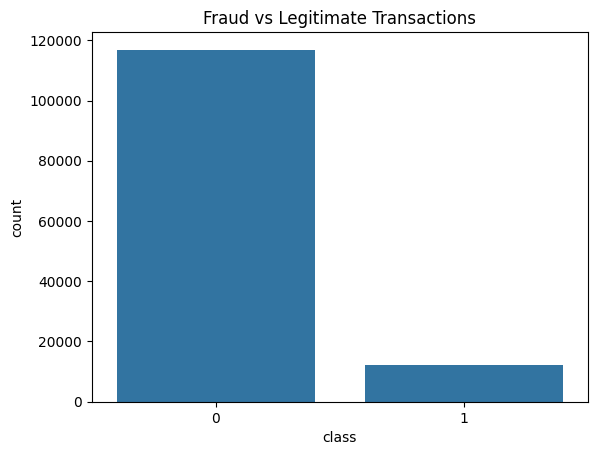

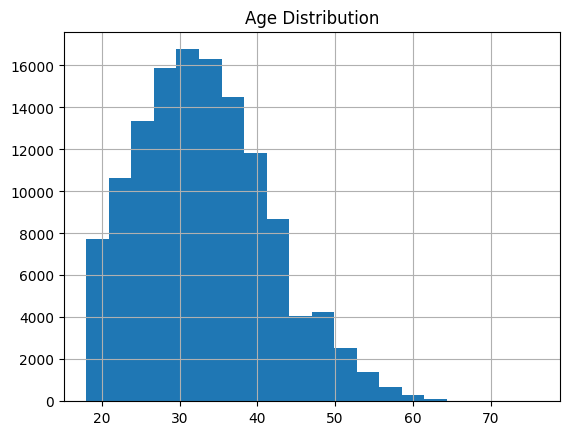

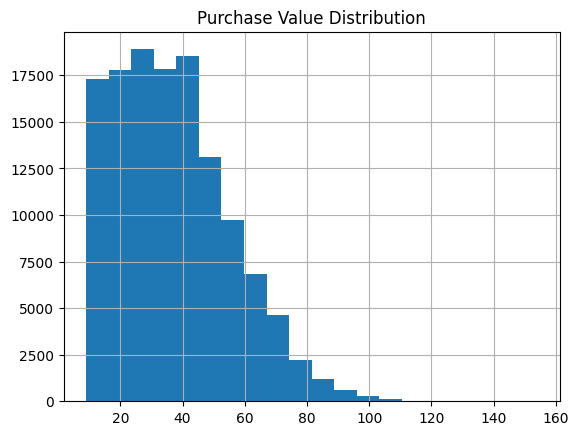

In [26]:
sns.countplot(x='class', data=merged_df)
plt.title('Fraud vs Legitimate Transactions')
plt.show()

merged_df['age'].hist(bins=20)
plt.title('Age Distribution')
plt.show()

merged_df['purchase_value'].hist(bins=20)
plt.title('Purchase Value Distribution')
plt.show()

Bivariate Analysis

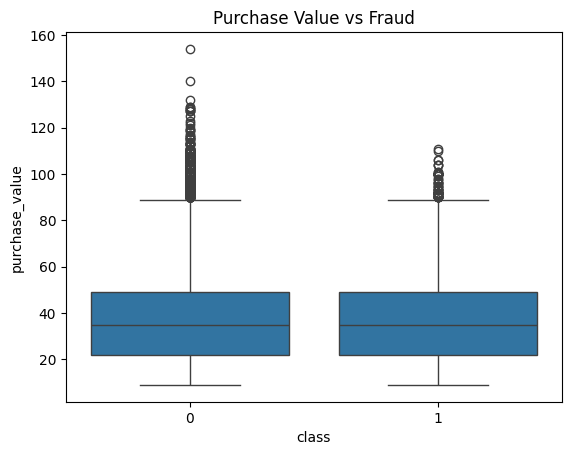

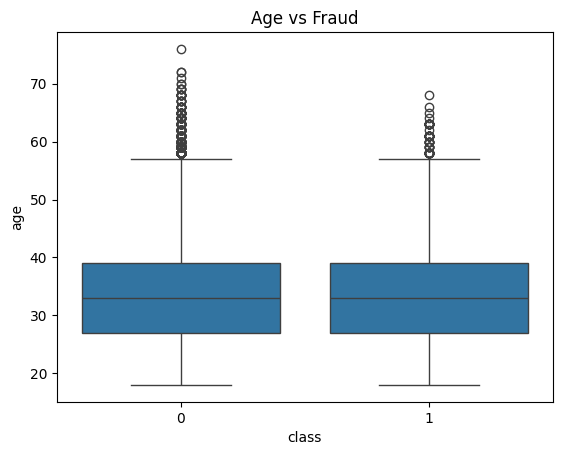

In [27]:
sns.boxplot(x='class', y='purchase_value', data=merged_df)
plt.title('Purchase Value vs Fraud')
plt.show()

sns.boxplot(x='class', y='age', data=merged_df)
plt.title('Age vs Fraud')
plt.show()

<Axes: xlabel='source'>

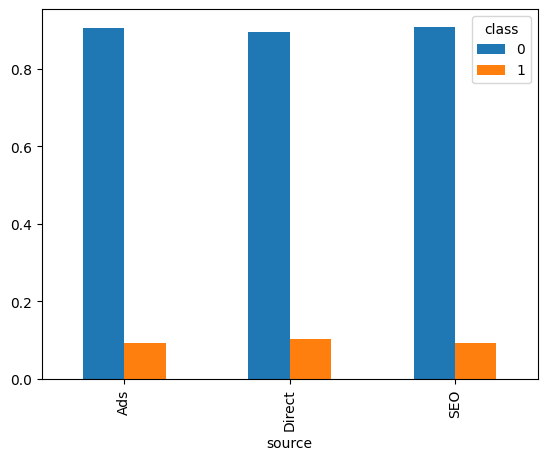

In [28]:
pd.crosstab(merged_df['source'], merged_df['class'], normalize='index').plot(kind='bar')

In [29]:
merged_df['time_since_signup'] = (merged_df['purchase_time'] - merged_df['signup_time']).dt.total_seconds()
merged_df['hour_of_day'] = merged_df['purchase_time'].dt.hour
merged_df['day_of_week'] = merged_df['purchase_time'].dt.dayofweek


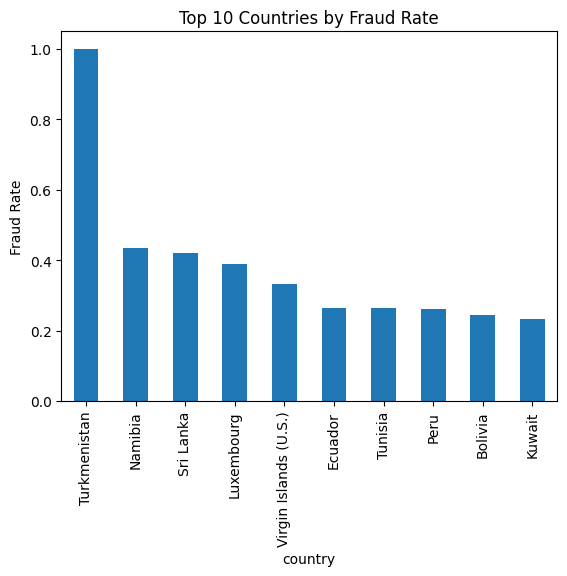

In [21]:
# Fraud rate by country
fraud_rate_by_country = merged_df.groupby('country')['class'].mean().sort_values(ascending=False).head(10)

fraud_rate_by_country.plot(kind='bar', title='Top 10 Countries by Fraud Rate')
plt.ylabel('Fraud Rate')
plt.show()

Country Analysis

In [30]:
country_fraud = merged_df.groupby(['country', 'class']).size().unstack(fill_value=0)

In [31]:
country_fraud['fraud_rate'] = country_fraud[1] / (country_fraud[0] + country_fraud[1])

In [32]:
country_fraud

class,0,1,fraud_rate
country,,,
Afghanistan,5,1,0.166667
Albania,13,0,0.000000
Algeria,109,13,0.106557
Angola,23,1,0.041667
Antigua and Barbuda,3,0,0.000000
...,...,...,...
Viet Nam,513,37,0.067273
Virgin Islands (U.S.),2,1,0.333333
Yemen,1,0,0.000000


In [33]:
country_fraud_sorted = country_fraud.sort_values(by='fraud_rate', ascending=False)

In [34]:
print(country_fraud_sorted.head(10))

class                   0   1  fraud_rate
country                                  
Turkmenistan            0   1    1.000000
Namibia                13  10    0.434783
Sri Lanka              18  13    0.419355
Luxembourg             44  28    0.388889
Virgin Islands (U.S.)   2   1    0.333333
Ecuador                78  28    0.264151
Tunisia                87  31    0.262712
Peru                   88  31    0.260504
Bolivia                40  13    0.245283
Kuwait                 69  21    0.233333


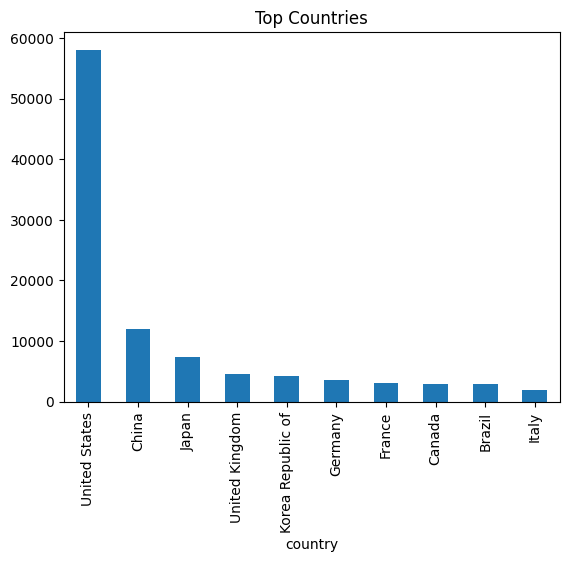

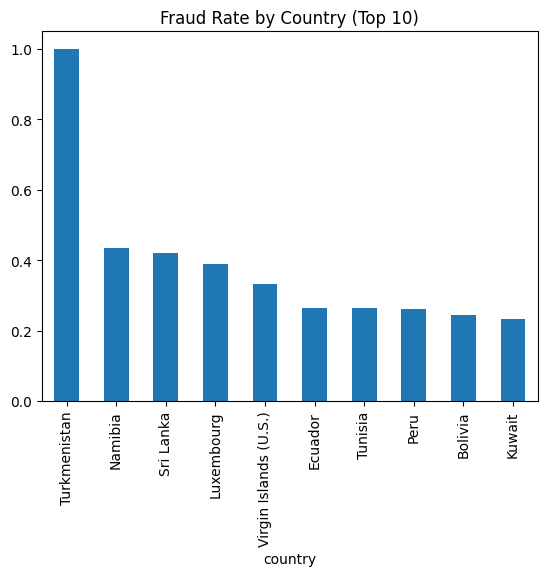

In [35]:
merged_df['country'].value_counts().head(10).plot(kind='bar', title='Top Countries')
plt.show()

# Fraud rate by country
merged_df.groupby('country')['class'].mean().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Fraud Rate by Country (Top 10)")
plt.show()


Feature Engineering

Transaction Frequency & Velocity

In [36]:
transaction_counts = merged_df.groupby('user_id')['purchase_time'].count().reset_index(name='transaction_count')

In [37]:
merged_df = merged_df.merge(transaction_counts, on='user_id', how='left')

Time-Based Features

In [38]:
merged_df['hour_of_day'] = merged_df['purchase_time'].dt.hour

In [39]:
merged_df['day_of_week'] = merged_df['purchase_time'].dt.dayofweek

In [40]:
merged_df['time_since_signup'] = (merged_df['purchase_time'] - merged_df['signup_time']).dt.total_seconds() / 3600  # in hours

In [41]:
merged_df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country,time_since_signup,hour_of_day,day_of_week,transaction_count
0,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,SEO,Safari,F,30,16778864,0,1.677824e+07,1.677926e+07,Australia,1008.948611,3,6,1
1,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,SEO,Chrome,F,34,16842045,0,1.680998e+07,1.684275e+07,Thailand,342.121389,20,2,1
2,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,Ads,IE,M,29,16843656,0,1.684326e+07,1.684378e+07,China,554.870556,23,5,1
3,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,Direct,Chrome,F,30,16938732,0,1.692467e+07,1.694106e+07,China,2122.471389,16,5,1
4,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,SEO,Chrome,F,37,16971984,0,1.694106e+07,1.697382e+07,Thailand,2847.105278,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129141,33024,2015-04-12 21:07:04,2015-05-12 22:42:35,56,PRYMTRKRYXEZC,Direct,Opera,F,18,3757992063,0,3.757965e+09,3.758031e+09,China,721.591944,22,1,1
129142,62132,2015-08-07 10:46:59,2015-08-27 22:35:23,36,XAZBVQEIGZMVM,Direct,Chrome,F,36,3758008198,0,3.757965e+09,3.758031e+09,China,491.806667,22,3,1
129143,363333,2015-02-09 07:56:12,2015-03-19 16:55:29,37,LPFTNUDBBWDVD,SEO,FireFox,M,42,3758018545,0,3.757965e+09,3.758031e+09,China,920.988056,16,3,1
129144,340800,2015-05-10 19:31:22,2015-05-15 09:27:33,9,VUDMWVCEHXMCV,Direct,Chrome,F,37,3758029146,0,3.757965e+09,3.758031e+09,China,109.936389,9,4,1


Class Imbalance Handling

In [42]:
# 1. Separate features and target
X = merged_df.drop(columns=['class'])
y = merged_df['class']

In [43]:
# Ensure cat_cols includes only object or category types
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Separate categorical and numeric columns
X_cat = X[cat_cols]
X_num = X.drop(columns=cat_cols)

# Convert numeric to consistent format (coerce any bad data to NaN and fill)
X_num = X_num.apply(pd.to_numeric, errors='coerce')  # convert to numeric
X_num = X_num.fillna(0)  # or X_num.dropna(), depending on your strategy


In [44]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE



# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat_encoded = encoder.fit_transform(X_cat)

# Combine sparse categorical matrix and dense numeric matrix
X_final = hstack([X_cat_encoded, X_num.values])  # .values ensures it's ndarray


In [45]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)


# SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_resampled.value_counts())

/home/samrawit/anaconda3/envs/kifiya/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/samrawit/anaconda3/envs/kifiya/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


After SMOTE: class
0    93502
1    93502
Name: count, dtype: int64


Data Transformation

Normalization and Scaling

In [46]:
from sklearn.preprocessing import StandardScaler

# Create a scaler that works with sparse data
scaler = StandardScaler(with_mean=False)

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Transform test data
X_test_scaled = scaler.transform(X_test)

In [47]:
merged_df.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'lower_bound_ip_address', 'upper_bound_ip_address', 'country',
       'time_since_signup', 'hour_of_day', 'day_of_week', 'transaction_count'],
      dtype='object')

In [48]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129146 entries, 0 to 129145
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   user_id                 129146 non-null  int64         
 1   signup_time             129146 non-null  datetime64[ns]
 2   purchase_time           129146 non-null  datetime64[ns]
 3   purchase_value          129146 non-null  int64         
 4   device_id               129146 non-null  object        
 5   source                  129146 non-null  object        
 6   browser                 129146 non-null  object        
 7   sex                     129146 non-null  object        
 8   age                     129146 non-null  int64         
 9   ip_address              129146 non-null  uint32        
 10  class                   129146 non-null  int64         
 11  lower_bound_ip_address  129146 non-null  float64       
 12  upper_bound_ip_address  129146

In [55]:
merged_df[['device_id']].nunique()

device_id    118434
dtype: int64

Encoding categorical attributes

In [56]:
from sklearn.preprocessing import OrdinalEncoder


merged_df = pd.get_dummies(merged_df, columns=['source', 'browser', 'sex'], drop_first=True)

In [57]:
merged_df

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,...,hour_of_day,day_of_week,transaction_count,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,30,16778864,0,1.677824e+07,1.677926e+07,...,3,6,1,False,True,False,False,False,True,False
1,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,34,16842045,0,1.680998e+07,1.684275e+07,...,20,2,1,False,True,False,False,False,False,False
2,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,29,16843656,0,1.684326e+07,1.684378e+07,...,23,5,1,False,False,False,True,False,False,True
3,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,30,16938732,0,1.692467e+07,1.694106e+07,...,16,5,1,True,False,False,False,False,False,False
4,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,37,16971984,0,1.694106e+07,1.697382e+07,...,4,1,1,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129141,33024,2015-04-12 21:07:04,2015-05-12 22:42:35,56,PRYMTRKRYXEZC,18,3757992063,0,3.757965e+09,3.758031e+09,...,22,1,1,True,False,False,False,True,False,False
129142,62132,2015-08-07 10:46:59,2015-08-27 22:35:23,36,XAZBVQEIGZMVM,36,3758008198,0,3.757965e+09,3.758031e+09,...,22,3,1,True,False,False,False,False,False,False
129143,363333,2015-02-09 07:56:12,2015-03-19 16:55:29,37,LPFTNUDBBWDVD,42,3758018545,0,3.757965e+09,3.758031e+09,...,16,3,1,False,True,True,False,False,False,True
129144,340800,2015-05-10 19:31:22,2015-05-15 09:27:33,9,VUDMWVCEHXMCV,37,3758029146,0,3.757965e+09,3.758031e+09,...,9,4,1,True,False,False,False,False,False,False
